# Buidling Connection Weights

@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn) 

In a brain model, connection weights, the amplititude of the influence presynaptic neurons have on postsynaptic neurons, are crucial to the dynamics and learning ability of the model. This section will illutrate how to build connection weights in a synapse model.

## Building Static Weights

Some computational models focus on the network structure and its influence on network dynamics, thus not modeling neural plasticity for simplicity. In this condition, synaptic weights are fixed and do not change in simulation.

### 1. Storing weights with a scalar

If all synaptic weights are designed to be the same, the single weights value can be stored as a scalar in the synpase model to save memory space. Let's review the *exponential synapse model* in [Building Synapse Models](synapse_models.ipynb):

In [1]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')


class Exponential(bp.TwoEndConn):
  def __init__(self, pre, post, conn, g_max=1., delay=0., E=0., tau=8.0, **kwargs):
    # connections are built in the initialization function of bp.TwoEndConn
    super(Exponential, self).__init__(pre=pre, post=post, conn=conn, **kwargs)

    # initialize parameters
    self.tau = tau
    self.g_max = g_max
    self.delay = delay
    self.E = E

    # acquire desired properties of the connection
    self.pre_ids, self.post_ids, self.pre2post = self.conn.requires('pre_ids', 'post_ids', 'pre2post')

    # variables
    self.s = bm.Variable(bm.zeros(self.post.num))
    self.pre_spike = self.register_constant_delay('pre_spike', self.pre.num, delay)

    self.integral = bp.odeint(f=self.derivative, method='exponential_euler')

  def derivative(self, s, t):
    dsdt = -s / self.tau
    return dsdt

  def update(self, _t, _dt):
    self.pre_spike.push(self.pre.spike)
    delayed_pre_spike = self.pre_spike.pull()
    
    # get the spikes of each presynaptic neuron
    spikes = bm.pre2syn(delayed_pre_spike, self.pre_ids)
    
    # transmit the spikes to postsynaptic neurons
    post_sp = bm.syn2post(spikes, self.post_ids, self.post.num)
    
    # update the synaptic state
    self.s[:] = self.integral(self.s, _t, dt=_dt) + post_sp

    # update the current output, i.e. the postsynaptic input
    self.post.input[:] += self.g_max * self.s * - (self.post.V - self.E)

The last line in the update update function refers to computing the current output onto the post-synaptic neuron:

$$
I_{syn}(t) = g_{max} s \left( V(t)-E \right)
$$

where $E$ is the reversal potential of the synapse, $V$ is the post-synaptic membrane potential, and $g_{max}$ is the maximum synaptic conductance. Here, **$g_{max}$** can be regarded as the connection weight of each synapse. This weight value is initialized and stored in `self.g_max`. When updating the synapse model, this weight is assigned to all synapses by scalar multiplication. 

### 2. Storing weights with a matrix

When the synaptic connection is dense and the synapses are assigned with different weights, weights can be stored in a matrix $W$, where $W(i, j)$ refers to the connection weight of presynaptic neuron $i$ to postsynaptic neuron $j$.

BrainPy provides `brainpy.training.initialize.Initializer` (or `brainpy.init` for short), the tutorial of which is displayed in [Initializing Connection Weights](../tutorial_training/initializing_connection_weights.ipynb), to initialize connection weights as a matrix.

For instance, if two neural groups are fully connected by exponential synapses with random weights, the exponential synapse model can be modified as below:

In [2]:
class ExpWeightMatrix(bp.TwoEndConn):
  def __init__(self, pre, post, conn, g_max, delay=0., E=0., tau=8.0, **kwargs):
    # connections are built in the initialization function of bp.TwoEndConn
    super(ExpWeightMatrix, self).__init__(pre=pre, post=post, conn=conn, **kwargs)

    # initialize parameters
    self.tau = tau
    self.delay = delay
    self.E = E
    self.g_max = bm.asarray(g_max)  # a matrix with a size of (self.pre.num, self.post.num)

    # acquire desired properties of the connection
    self.pre_ids, self.post_ids, self.pre2post = self.conn.requires('pre_ids', 'post_ids', 'pre2post')

    # variables
    self.s = bm.Variable(bm.zeros(self.post.num))
    self.pre_spike = self.register_constant_delay('pre_spike', self.pre.num, delay)

    self.integral = bp.odeint(f=self.derivative, method='exponential_euler')

  def derivative(self, s, t):
    dsdt = -s / self.tau
    return dsdt

  def update(self, _t, _dt):
    self.pre_spike.push(self.pre.spike)
    delayed_pre_spike = self.pre_spike.pull()
    
    spikes = bm.pre2syn(delayed_pre_spike, self.pre_ids)
    
    post_sp = bm.syn2post(spikes, self.post_ids, self.post.num)
    
    self.s[:] = self.integral(self.s, _t, dt=_dt) + post_sp

    self.post.input[:] += self.g_max * self.s * - (self.post.V - self.E)

`bp.models.LIF` is used to construct the pre- and post-synaptic neural groups:

In [3]:
LIF = bp.models.LIF

pre_size = (4, 4)
post_size = (3, 3)
pre_neu = LIF(pre_size, tau=10, V_th=-30, V_rest=-60, V_reset=-60, tau_ref=5.)
post_neu = LIF(post_size, tau=20, V_th=-30, V_rest=-60, V_reset=-60, tau_ref=5.)
conn = bp.connect.All2All()

Before instantiation, a weight matrix can be constructed using `brainpy.init.Uniform`, which initializes weights with a random distribution:

In [4]:
uniform_init = bp.init.Uniform(min_val=0., max_val=1.)
weights = uniform_init((pre_size, post_size))
print('shape of weights: {}'.format(weights.shape))

shape of weights: (16, 9)


Then, the weight matrix can be used for `ExpWithWeightMatrix` initialization:

In [8]:
exp_syn = ExpWeightMatrix(pre_neu, post_neu, conn, weights, E=0., tau=5.)

### 3. Storing weights with a vector

When the synaptic connection is sparse, using a matrix to store connection weights is too wasteful. Instead, the weights can be stored in a vector which has the same length as the synaptic connections.

<img src="../_static/synapses_and_weights.png" width="400 px">

In the update function of the synapse model, weights can be assigned to the corresponding synapses as long as the they are aligned with each other.

for users who would like to obtain the weight vector from the weight matrix, BrainPy also provides the `xxxx` function:

In [9]:
# matrix2vector illustration

However, it is not recommended to use this function when the connection is sparse and of a large scale, because generating the weight matrix will take up too much space.

Below is an example of using the weight vector in the exponential synapse model:

In [10]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')


class ExpWeightVector(bp.TwoEndConn):
  def __init__(self, pre, post, conn, weights, g_max=1., delay=0., E=0., tau=8.0, **kwargs):
    # connections are built in the initialization function of bp.TwoEndConn
    super(ExpWeightVector, self).__init__(pre=pre, post=post, conn=conn, **kwargs)

    # initialize parameters
    self.tau = tau
    self.g_max = g_max
    self.delay = delay
    self.E = E
    self.weights = bm.asarray(weights) # a vector with a length of the number of synapses

    # acquire desired properties of the connection
    self.pre_ids, self.post_ids, self.pre2post = self.conn.requires('pre_ids', 'post_ids', 'pre2post')

    # variables
    self.s = bm.Variable(bm.zeros(self.post.num))
    self.pre_spike = self.register_constant_delay('pre_spike', self.pre.num, delay)

    self.integral = bp.odeint(f=self.derivative, method='exponential_euler')

  def derivative(self, s, t):
    dsdt = -s / self.tau
    return dsdt

  def update(self, _t, _dt):
    self.pre_spike.push(self.pre.spike)
    delayed_pre_spike = self.pre_spike.pull()
    
    # each spike is timed by its synaptic weights
    spikes = bm.pre2syn(delayed_pre_spike, self.pre_ids) * self.weights
    
    post_sp = bm.syn2post(spikes, self.post_ids, self.post.num)
    
    self.s[:] = self.integral(self.s, _t, dt=_dt) + post_sp

    self.post.input[:] += self.g_max * self.s * - (self.post.V - self.E)

Two groups of LIF neurons are connected one by one:

In [57]:
pre_size = post_size = 3
pre_neu = LIF(pre_size, tau=10, V_th=-30, V_rest=-60, V_reset=-60, tau_ref=5.)
post_neu = LIF(post_size, tau=20, V_th=-30, V_rest=-60, V_reset=-60, tau_ref=5.)

conn = bp.connect.One2One()

weights = bm.array([9., 5., 1])
print('connection weights: {}'.format(weights))

exp_syn = ExpWeightVector(pre_neu, post_neu, conn, weights, E=0., tau=5.)

connection weights: [9. 5. 1.]


Simulation of the model (for more details about building a network, please see [Building Network Models](network_models.ipynb)):

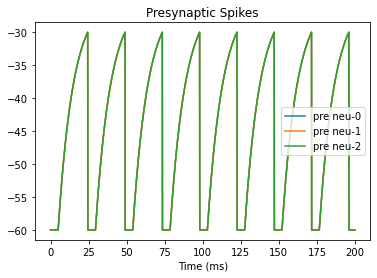

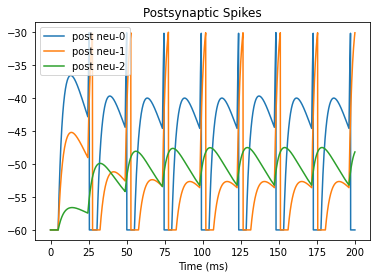

In [58]:
net = bp.Network(exp_syn, pre=pre_neu, post=post_neu)

runner = bp.StructRunner(net, monitors=['pre.V', 'post.V'], inputs=[('pre.input', 35.)])
runner.run(200)

bp.visualize.line_plot(runner.mon.ts, runner.mon['pre.V'], plot_ids=(0, 1, 2), legend='pre neu',
                       title='Presynaptic Spikes', show=True)
bp.visualize.line_plot(runner.mon.ts, runner.mon['post.V'], plot_ids=(0, 1, 2), legend='post neu',
                       title='Postsynaptic Spikes', show=True)

It can be seen that the larger the weight, the greater the postsynaptic output current is. For postsynaptic neuron-2, the output current is too small to generate a spike.

## Building Dynamic Weights

Sometimes users may want to realize neural plasticity in a brain model, which requires the connection weights to change during simulation. In this condition, weights should be considered as **variables**, and the change of weights should be realized in the update function of the synapse model.